(bayes-cohorts)=
# Inferring Skill With Bayes Theorem

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from spells import summon, ColType, ColName, ColSpec
from spells import extension

In [2]:
# Uncomment to run. This cell will use several GB of bandwidth and about a GB of storage on your machine to enable the below analysis.
# Probably better to do it from a real terminal.

# !spells add DSK
# !spells add BLB
# !spells add OTJ


## Introduction 
I want to do something a little different and write up some mathematical results related to limited analysis in complete detail. The target for this is any student of mathematics that could use their interest in Magic as a bit of extra motivation. This is university-level probability theory, but calculus students might be able to follow along with some imagination. There will be a lot of math, and a little bit of scientific programming.

First, let's set out the nature of the problem. We want to assign skill estimates to players with observed win rates that look like this:

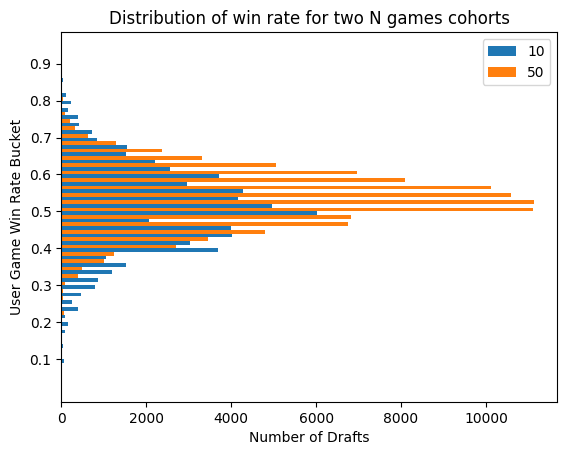

In [3]:
sets = ["DSK", "BLB", "OTJ"]
UWR = ColName.USER_GAME_WIN_RATE_BUCKET
UNG = ColName.USER_N_GAMES_BUCKET
ND = ColName.NUM_DRAFTS

_, ax = plt.subplots()
for i, cohort in enumerate([10, 50]):
    df = summon(sets, columns=[ND], group_by=[UWR], filter_spec={UNG: cohort})
    ax.barh(df[UWR] - 0.005 + 0.01 * i, df[ND], height=0.01, label=cohort)

ax.set_yticks(np.arange(0.1, 1, 0.1))
ax.set_title("Distribution of win rate for two N games cohorts")
ax.set_xlabel("Number of Drafts")
ax.set_ylabel("User Game Win Rate Bucket")

ax.legend()
plt.show()

This might not look so bad, but we see some very extreme win rates, north of 75%. And even the not so extreme ones, do we want to lump someone that went 6-3 with someone that went 600-300? In general, we have the intuition that we need some more evidence before we assign someone a high win rate. Can we quantify that systematically? Certainly! Can we do it simply, or do we need a comprehensive theory? We can do it simply, but today we are going to look at a comprehensive theory, that happens to have a simple and intuitive result.

Let's consider the problem of estimating win rates. A win rate is a statistic (meaning, a computation on a data set) that is presumed to be driven by some *skill parameter* $\lambda$. Then the outcome of each game is a Bernoulli random variable 

$$
W_n = \begin{cases} 1 & \text{with probability} & \lambda \\ 0 & \text{with probability} & 1-\lambda. \\ \end{cases}
$$

Bernoulli, meaning a guy that got nearly the simplest thing imaginable named after him, and random variable, meaning, a variable ($W$) which takes on some value or another according to a random distribution.  Both random and a variable, contrary to what you might have heard. Suppose we observe a series of $w$ wins ($1$s) and $l$ losses ($0$s) by politely and repeatedly asking $W$ for it's value. What is our estimate of $\lambda$? A straightforward thing to do is to take the mean, which is also just the observed win rate, and let

$$
\hat\lambda = \frac{w}{w+l}.
$$

e.g., 40% for 4 wins and 6 losses. But what if we observe a small number of games, and the ratio between $w$ and $l$ is extreme? We don't presume that after we watch a player win one game that they are likely to win the rest. Instead, we assume that their skill parameter is likely close to average, perhaps a bit higher based on the result we just witnessed. So we would like to formalize that idea. Bayes suggests that instead of having a fixed parameter representing our knowledge of their skills, we instead choose a *prior distribution*, that is, create a random variable that represents our model of their skill, and update the distribution of that variable when we make observations. But how do we choose our prior? Let's not. Let's just suppose that $\Lambda$ (now capitalized because it's random) has a continuous distribution described by a density function $f_\Lambda: (0,1) \rightarrow \mathbb{R}^+$, meaning our random variable $\Lambda$ takes on values between $0$ and $1$, and can fall in any range with some positive probability. This makes sure we can land at any spot in that interval for our value $\hat{\lambda}$ once we see enough games.

## Bayes Theorem

Bayes theorem states that for events $A$ and $B$ under a probability measure $\mathbf{P}$, 

$$
\mathbf{P}(A|B) = \frac{\mathbf{P}(B|A) \cdot \mathbf{P}(A)}{\mathbf{P}(B)}.
$$

The bar means "conditional on", so the interpretation is that our updated estimate of the likelihood of $B$, once we know whether or not $A$ happened, can be derived if we know how to calculate the likelihood of $A$ given $B$, and the underlying rates. That is exactly our situation. We want a whole distribution (for $\Lambda$), not just an event, but we will be a bit cheeky and just say $\mathbf{P}(\Lambda \in dx)$ where $dx$ is shorthand for the interval $[x, x+dx]$, and this $dx$ is shorthand for some number small enough to get the accuracy we need. See a probability textbook for a proper definition, but professionals do this kind of thing all the time. So this expression with the "in" sign $\in$ is an event, either the value for $\Lambda$ lands in that interval or it doesn't. For a smooth distribution like the one we are working with (thanks to our choice of prior), this will be a function of $x$ with a $dx$ factor, which we can divide out to obtain the density function. Our other event is $W$ (or $W^c$), the event of a win (or loss). Let's rewrite the thing we want with our new variables:

$$
\mathbf{P}(\Lambda \in dx|W) = \frac{\mathbf{P}(W|\Lambda \in dx) \cdot \mathbf{P}(\Lambda \in dx)}{\mathbf{P}(W)}.
$$

So the left-hand side is what we want, it's the new distribution for $\Lambda$. Well, it's one event, but it tells us the value of a new density function at $x$ describing our updated guess at $\Lambda$ given the observation $W$ (a win, in this case. We will have to derive both formulas).

$\mathbf{P}(W|\Lambda \in dx)$ looks intimidating, but the condition is that $\Lambda$ is constrained to be very close to a fixed value $x$, and we know what to do when $\Lambda$ is fixed. We check our Bernoulli distribution above and see that the value must be $x$. $\mathbf{P}(\Lambda \in dx)$ is just our density function, or more properly, our density function times $dx$, so $f_\Lambda(x)dx$. That leaves $\mathbf{P}(W)$, which looks inoccuous, but actually is the only tricky thing here. We forgot to mention how to estimate the likelihood of winning for a random skill parameter! We'll have to resort to what we know, which is the value given $x$. 

With conditional probabilities you can do a trick where you wrap a conditional probability inside of another probability, like this:

$$
\mathbf{P}(W) = \mathbf{P}(\mathbf{P}(W|\Lambda)).
$$

Don't forget this one! Yes I cheated and we're conditioning on a variable, not an event, but it's essentially the same object as the $dx$ version. There's no great way to write it otherwise. But you can follow this: the interpretation is, "the chance Anson wins the game is the same as the chance that Anson wins the game after I whisper his skill parameter in your ear". Not exactly mind-blowing, but we can calculate the second version, because once we know the parameter we know the chance he will win, and we also have a distribution of the parameter so we can guess how often each different whisper will happen.

Now if the parameter is $\Lambda$ (which, remember is a random variable -- a variable which represents a number underneath a distribution), we check Bernoulli's distribution again and the probability of winning is... $\Lambda$, right. So our formula becomes:

$$
\mathbf{P}(W) = \mathbf{P}(\Lambda).
$$


You're used to seeing an $\mathbf{E}$ here, for expectation, but I learned probability from an maverick so I do it this way. It's just an integral sign anyway:

$$
\mathbf{P}(\Lambda) = \int_0^1{xf_\Lambda(x)dx}.
$$

That's the expectation of $\Lambda$ under the probability measure given by the density function $f_\Lambda$. It's notation, not a formula. Don't forget the $x$! That's the $\Lambda$ in the $\mathbf{P}$ version. Now we can write down our whole formula:

$$
\mathbf{P}(\Lambda \in dx|W) = \frac{xf_\Lambda(x)dx}{\int_0^1{xf_\Lambda(x)dx}}.
$$

Uh, ok. Did we do anything here? Looks like $1$? Well it is, in an important way. Throw another integral sign there, and you do get $1$, which means we have ourselves a probability density function, and that means we have a new distribution! It's also a good reminder that you often don't need the denominator to work with Bayes' rule, which is nice because it's usually the hardest part to calculate.

Let's start giving out distributions names, let's identify them by the number of wins and losses observed, like this:

$$
f_{1,0}(x) = \frac{xf_{0,0}(x)}{\int_0^1{xf_{0,0}(x)dx}}.
$$

We divided out the $dx$, we didn't forget it.

The denominator is going to start getting annoying, so I'm just going to leave it out and use a $\sim$ symbol to denote proportionality. Go back and repeat the argument with a loss, and we get the formula

$$
f_{0,1}(x) \sim (1-x)f_{0,0}(x).
$$

Now, the whole idea is that our new distribution is our prior next time we make an observation. So if we see a win after that first loss, we can do this:

$$
f_{1,1}(x) \sim xf_{0,1}(x) \sim x(1-x)f_{0,0}(x).
$$

Rack up $w$ wins and $l$ losses, and we have 

$$
f_{w,l}(x) \sim x^w(1-x)^lf_{0,0}(x).
$$

This is almost beautiful! It's just that ugly $f_{0,0}$ to be dispensed with. If we see enough data, can't we forget about it anyway? Let's just think about this as a family of functions. You get some $x$'s and some $(1-x)$'s and maybe that's all you need. Let $f_{0,0}(x) = 1$, which is a nice distribution called the *uniform distribution*, and we are left with this:

$$
f_{w,l}(x) = \frac{x^w(1-x)^l}{Z}.
$$

$Z$ just means whatever we need to divide by to get a total probability of $1$. It doesn't matter that the uniform distribution is a lousy assumption about player skill, because we aren't going to use it. We're going to use a member of our new family, because once we can reason about the members of that family we can choose an appropriate one as our prior. 

## Beta Distributions

I guess we should learn how to reason about these distributions. They're called beta distributions, by the way, and you can get all this information over on Wikipedia. But I wanted to write it up my way, so I didn't even cross-reference the artcle. Let's graph a few of them. Let's see what happens to the distribution over the sequence $(W, W, L, L)$.

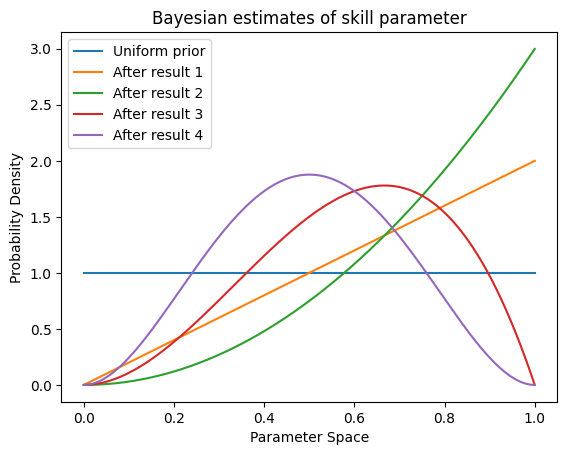

In [4]:
N = 1000
x = np.linspace(0, 1, N)
f_0 = np.full(N, 1)  # our uniform prior


def normalize(f):
    "should sum to N"
    return f / f.sum() * N


def update(prior, result):
    "tell me this isn't a nice update function"
    return normalize((x if result else (1 - x)) * prior)


_, ax = plt.subplots()

f = f_0
wl_seq = [1, 1, 0, 0]

ax.plot(x, f, label="Uniform prior")
for i, res in enumerate(wl_seq):
    f = update(f, res)
    ax.plot(x, f, label=f"After result {i+1}")
ax.set_title("Bayesian estimates of skill parameter")
ax.set_xlabel("Parameter Space")
ax.set_ylabel("Probability Density")
ax.legend()
plt.show()

After the second result, the green line, it looks like we're leaning towards a skill parameter of $1.0$. While that's not realistic in real life, remember that our prior likes $1.0$ just as much as any other number, so it makes sense that we lean that way after a series of wins. A few wins and losses, and we are starting to get something with a centered shape. Let's look at a few for larger random samples.

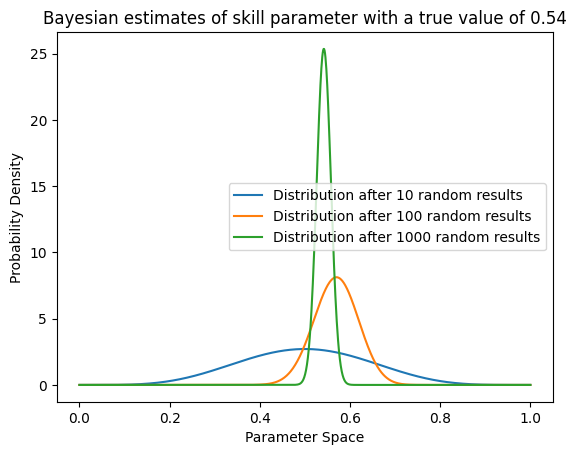

In [5]:
_, ax = plt.subplots()
lam = 0.54
for n in [10, 100, 1000]:
    results = np.random.random(n) < lam

    f = f_0
    for result in results:
        f = update(f, result)

    ax.plot(x, f, label=f"Distribution after {n} random results")
ax.set_title("Bayesian estimates of skill parameter with a true value of 0.54")
ax.set_xlabel("Parameter Space")
ax.set_ylabel("Probability Density")
ax.legend()
plt.show()

It takes time to build confidence! Even after 100 results, it looks like our estimate could range anywhere in a ~20% window based on the random results we observed. After 1000 we are starting to build some confidence, but it's hard to quantify based on the graph alone. Remember, this is a theoretical distribution based on a single random sample, not a distribution of random results. This is the beauty of Bayesian statistics, that our posterior distribution can encode the uncertainty of our random process.

OK, but looking at the graph is one thing, we'd like to know what the distribution's mean and variance is. Remember, the mean is also the win rate estimate, so that's important. And we are going to use the variance to choose a prior. Let's calculate. Recall formulas for mean and variance:

$$
\begin{align}
\mu(\Lambda) &= \mathbf{P}(\Lambda) = \int_0^1{xf_\Lambda(x)dx}\\
\text{Var}(\Lambda) &= \mathbf{P}(\Lambda^2) - \mu(\Lambda)^2 = \int_0^1{x^2f_\Lambda(x)dx} - \mu(\Lambda)^2.
\end{align}
$$

So to calculate $\mu$ with our indexed probability distributions, we get

$$
\mu_{w,l} = \frac{\int_0^1{x^{w+1}(1-x)^l dx}}{\int_0^1{x^{w}(1-x)^l dx}}.
$$

Looks like we will have to remember our integral calculus. What's the one where you split the expression in half and take the derivative of one side? That's right, integration by parts. Assume $l \geq 1, k \geq 0$ and let

$$
\begin{align}
u &= (1-x)^l & du &= -l(1-x)^{l-1} \\
dv &= x^k & v &= \frac{1}{k+1}x^{k+1}.\\
\end{align}
$$

Then

$$
\begin{align}
\int_0^1{x^k(1-x)^l dx} &= \frac{1}{k+1}x^{k+1}(1-x)^l \Bigr]_0^1 - \int_0^1{\frac{-l}{k+1}x^{k+1}(1-x)^{l-1}dx} \\
&= \frac{l}{k+1}\int_0^1{x^{k+1}(1-x)^{l-1}dx}.
\end{align}
$$

We recursively work our way down to $l=0$ and get 

$$
\frac{l!}{(k+l) \cdots (k+1)} \int_0^1 x^{k+l}dx = \frac{l!}{(k + l +1) \cdots (k+1)}.
$$

Substitute $\mu_{w,l}$ and we get

$$
\mu_{w,l} = \frac{l!}{(w+l+2) \cdots (w+2)} \cdot \frac{(w+l+1) \cdots (w+1)}{l!} = \frac{w+1}{w+l+2}.
$$

You can verify that this works for $l=0$ as well.

Well this is particularly nice. It looks just like our sample win rate calculation with a bit extra to keep from locking ourselves in at $0$ or $1$. In fact, we can think of the uniform distribution as supplying us with an extra win and a loss, so if we say $w_0 = 1$ and $l_0 = 1$, then we get 

$$
\hat\lambda = \mu_{w,l} = \frac{w+w_0}{w+w_0+l+l_0}.
$$

We're almost ready to choose a sensible prior. It's not hard to see that we can pick arbitrary values for $w_0$ and $l_0$ (even non-integers! They won't bite. If you notice that the formula is well-behaved in $w$ and $l$ even though we used factorial calculations in our derivation, you are beginning to get the idea of the [gamma function](https://en.wikipedia.org/wiki/Gamma_function)), and there's a member of our distribution family that corresponds that that choice when used as a prior. 

## Choosing a Prior

So what we've found, after all this calculation, is that choosing a Bayesian prior for skill estimation is equivalent to preloading our sample with some wins and losses. I think that is a very cool result. But we're not done. How do we choose $w_0$ and $l_0$? Well, we should pick a sensible rate to start. For 17Lands data, users tend to have a winrate of about 54%, so we'll let $w_0 = 0.54(w_0 + l_0)$. To choose the prior sample size (that is, $w_0 + l_0$), we should look at the expected variance of skill. We want our prior to represent the distribution of skill in the population, which we can do by matching variance. 

Let's look at one bucket of users to simplify things, those with 50-100 games. We'll assume that they played 75 games each, so the variance in their observed win rate, assuming fixed skill, should be

$$
\text{Var} = 0.54 \cdot 0.46 / 75 \sim 3.3 \cdot 10^{-3}.
$$

Let's see what the sample gives us. I have a built-in function to get the pool-weighted variance of any metric, which will do fine for this. Strictly speaking, we should draft-weight, but we don't need an exact answer here.

In [6]:
wr_stats = extension.stat_cols(UWR, silent=True)
var_col = "user_game_win_rate_bucket_pw_var"
summon(
    sets, columns=[var_col], group_by=[UWR], filter_spec={UNG: 50}, extensions=wr_stats
)[0][var_col]

user_game_win_rate_bucket_pw_var
f64
0.00546


The number of samples and the variance in skill are nearly independent sources of randomness, so it will be fine to subtract here. Our estimate of the variance of the distribution of player skill (for this bucket anyway) is then about $0.0022$. Oh, we forgot to calculate the variance of our distribution. Let's do that now.

$$
\text{Var}(\Lambda) = \mathbf{P}(\Lambda^2) - \mu(\Lambda)^2,
$$

and

$$
\begin{align}
\mathbf{P}(\Lambda^2) &= \frac{\int_0^1{x^{w+2}(1-x)^l dx}}{\int_0^1{x^{w}(1-x)^l dx}}\\
    &= \frac{l!}{(w+l+3) \cdots (w+3)} \cdot \frac{(w+l+1) \cdots (w+1)}{l!}\\
    &= \frac{(w+2)(w+1)}{(w+l+3)(w+l+2)},
\end{align}
$$

so

$$
\begin{align}
\text{Var}(\Lambda) &= \frac{(w+2)(w+1)}{(w+l+3)(w+l+2)} - \frac{(w+1)^2}{(w+l+2)^2} \\ 
&= \frac{(w+1)(l+1)}{(w+l+2)(w+l+2)(w+l+3)},
\end{align}
$$

which you can expand out and verify.

It's not pretty, but when you realize the heavy lifting the formula is doing, the elegance comes into view. Here are a few facts this formula should satisfy:

* For the uniform distribution ($w = l = 0$), we should get $\int_{-1/2}^{1/2}x^2dx = 1/12$. Check.
* It should scale like $1/n$, since it represents our uncertainty after $n$ observations. Check.
* $n \text{Var}(\Lambda)$ should converge to $\lambda (1-\lambda$) for large $n$. Also check.

The reasons for this I will leave as an excercise! But we have a formula, so we can convert our variance to a sample size. Solve

$$
0.0022 = \frac{0.54 \cdot 0.46} {n+1},
$$

(look familiar?), and we get... wait...

In [7]:
0.54 * 0.46 / 0.0022 - 1

111.90909090909092

112 games!

So that's it, our final estimator of win rate for a player with $w$ wins and $l$ losses, or a player with $\bar{\lambda}$ win rate and $n$ games played, is

$$
\begin{align}
\hat{\lambda} &= \frac{w + 0.54 \cdot 112}{w + l + 112}\\ &= \frac{\bar{\lambda} n + 0.54 \cdot 112}{n + 112} \\
&= 0.54 + (\bar\lambda - 0.54) \cdot \frac{n}{n+112}.
\end{align}
$$

I use the last formula because it's a bit more convenient as a one-liner. Hmm, shouldn't we consider the effect of rank? Another exercise for the reader... 

Let's see what that looks like mapped to our cohorts. I'm going to pick some values of average games played by each n-games bucket. We could do this scientifically but I've had enough science for one day.

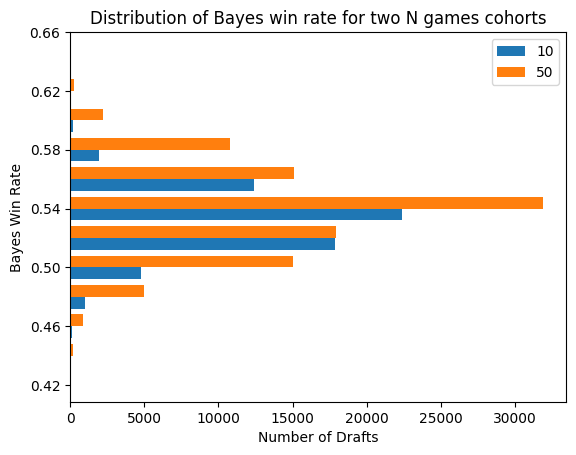

In [8]:
BAYES_MU = 0.54
BAYES_N = 112

ext = {
    "bayes_wr": ColSpec(
        col_type=ColType.GROUP_BY,
        expr=(
            (
                pl.when(pl.col(UNG) == 1000)
                .then(1200 / (1200 + BAYES_N))
                .otherwise(
                    pl.when(pl.col(UNG) == 500)
                    .then(700 / (700 + BAYES_N))
                    .otherwise(
                        pl.when(pl.col(UNG) == 100)
                        .then(250 / (250 + BAYES_N))
                        .otherwise(
                            pl.when(pl.col(UNG) == 50)
                            .then(70 / (70 + BAYES_N))
                            .otherwise(
                                pl.when(pl.col(UNG) == 10)
                                .then(25 / (25 + BAYES_N))
                                .otherwise(0)
                            )
                        )
                    )
                )
                * (pl.col(UWR) - BAYES_MU)
                + BAYES_MU
            )
            * 50
        ).round()
        / 50,
    ),
}

_, ax = plt.subplots()
for i, cohort in enumerate([10, 50]):
    df = summon(
        sets,
        columns=[ND],
        group_by=["bayes_wr"],
        filter_spec={UNG: cohort},
        extensions=ext,
    )
    ax.barh(df["bayes_wr"] - 0.004 + 0.008 * i, df[ND], height=0.008, label=cohort)

ax.set_yticks(np.arange(0.42, 0.66, 0.04))
ax.set_title("Distribution of Bayes win rate for two N games cohorts")
ax.set_xlabel("Number of Drafts")
ax.set_ylabel("Bayes Win Rate")

ax.legend()
plt.show()

This looks much nicer! We have fewer groups with a more reasonable distribution, and we can observe more confidence in higher skill for some of the players with more reps. Let's add a few more buckets to see the big picture.

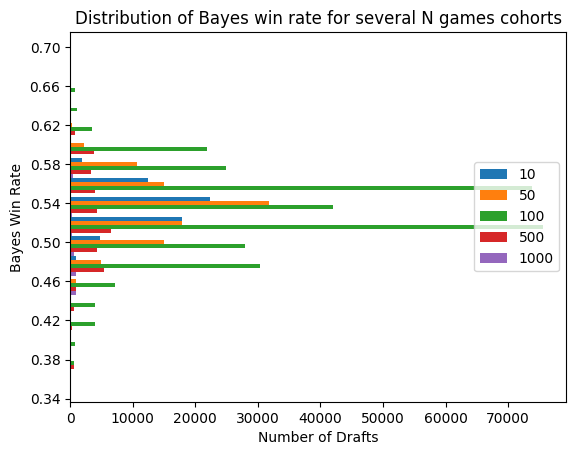

In [9]:
prop = summon(sets, columns=[ND], group_by=["bayes_wr"], extensions=ext).rename(
    {ND: "_"}
)

_, ax = plt.subplots()
for i, cohort in enumerate([10, 50, 100, 500, 1000]):
    df = summon(
        sets,
        columns=[ND],
        group_by=["bayes_wr"],
        filter_spec={UNG: cohort},
        extensions=ext,
    )
    df = prop.join(df, on=["bayes_wr"], how="left")

    ax.barh(
        df["bayes_wr"] - 0.02 * i / 5 + 0.004,
        df[ND],
        height=0.02 / 5,
        label=str(cohort),
    )

ax.set_yticks(np.arange(0.34, 0.74, 0.04))
ax.set_xlabel("Number of Drafts")
ax.set_ylabel("Bayes Win Rate")

ax.set_title("Distribution of Bayes win rate for several N games cohorts")
ax.legend()
plt.show()

Looks pretty good! The shapes for the different cohorts at least look similar. Although that bimodal bit is pretty weird. I wonder what's going on there...

## Conclusion

We've come up with a nice way to map our records to skill estimates of the players producing the data. There are a couple ways we could use that skill estimate that could lead to better analysis. First, when interpreting card winrates, the skill of the player who chose the card is an important source of bias. We want to estimate how we might perform with the card, not find out how good the player was that picked it. An accurate skill estimate could allows to correct for that bias.

Second, we can learn from the choices of skilled players. If we are training a model or evaluating choices driven by a quantitative factor, we can ask how players at different skill levels made choices in a similar situation and use that to inform our model. Ultimately, player skill drives game outcomes as much or more than any given data point, so estimating it accurately is necessary for improving the quality of our analytics.